## Imports

In [1]:
import os

import random
import numpy as np
import keras

import tensorflow as tf

import matplotlib.pyplot as plt

import keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

2022-12-23 18:39:02.944764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 18:39:03.225612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 18:39:03.225644: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 18:39:04.232155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
tf.__version__

'2.11.0'

## Dataset

In [3]:
!echo "Downloading 101_Object_Categories for image notebooks"
!wget https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip
!unzip caltech-101.zip
!tar -xzf caltech-101/101_ObjectCategories.tar.gz
!rm caltech-101/101_ObjectCategories.tar.gz
!ls

In [3]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/scissors', '101_ObjectCategories/lamp', '101_ObjectCategories/wild_cat', '101_ObjectCategories/strawberry', '101_ObjectCategories/trilobite', '101_ObjectCategories/mayfly', '101_ObjectCategories/cougar_face', '101_ObjectCategories/menorah', '101_ObjectCategories/elephant', '101_ObjectCategories/accordion', '101_ObjectCategories/brontosaurus', '101_ObjectCategories/pigeon', '101_ObjectCategories/tick', '101_ObjectCategories/ketch', '101_ObjectCategories/chair', '101_ObjectCategories/rooster', '101_ObjectCategories/laptop', '101_ObjectCategories/barrel', '101_ObjectCategories/lotus', '101_ObjectCategories/rhino', '101_ObjectCategories/sunflower', '101_ObjectCategories/binocular', '101_ObjectCategories/watch', '101_ObjectCategories/lobster', '101_ObjectCategories/crocodile', '101_ObjectCategories/schooner', '101_ObjectCategories/camera', '101_ObjectCategories/ant', '101_ObjectCategories/bass', '101_ObjectCategories/gramophone', '101_ObjectCategories/snoopy', '101_Ob

In [4]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [6]:
random.shuffle(data)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[9, 83, 46, 23, 39, 95, 33, 72, 86, 95, 9, 13, 12, 23, 31, 63, 93, 15, 87, 42, 48, 85, 44, 16, 37, 22, 61, 22, 13, 93, 7, 93, 57, 79, 6, 67, 20, 24, 72, 48, 82, 96, 60, 38, 19, 51, 90, 58, 39, 64, 15, 45, 89, 75, 60, 90, 29, 28, 45, 70, 75, 55, 62, 77, 87, 47, 51, 67, 58, 43, 26, 65, 87, 45, 93, 96, 33, 40, 43, 8, 66, 39, 13, 60, 60, 38, 81, 26, 4, 25, 52, 14, 16, 1, 31, 13, 55, 72, 56, 46, 43, 50, 19, 17, 87, 42, 0, 56, 79, 27, 45, 67, 38, 34, 4, 51, 92, 82, 45, 4, 91, 47, 35, 37, 56, 36, 82, 37, 18, 19, 13, 85, 68, 32, 32, 15, 31, 31, 3, 96, 58, 18, 84, 14, 69, 84, 89, 96, 61, 57, 88, 64, 22, 58, 66, 22, 33, 96, 94, 70, 38, 10, 38, 39, 30, 94, 93, 34, 79, 66, 54, 28, 51, 29, 77, 64, 14, 16, 96, 48, 52, 80, 18, 47, 24, 42, 7, 84, 47, 70, 94, 35, 94, 43, 57, 81, 87, 7, 82, 94, 53, 77, 38, 68, 72, 47, 37, 6, 55, 68, 53, 1, 37, 13, 25, 81, 10, 48, 25, 57, 38, 13, 58, 93, 16, 50, 3, 35, 4, 22, 41, 86, 0, 45, 25, 87, 46, 37, 22, 84, 93, 17, 89, 57, 7, 5, 23, 49, 96, 95, 82, 26, 16, 69, 38,

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


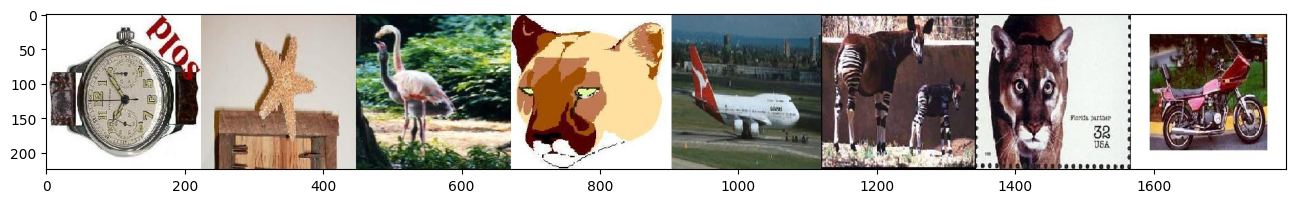

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

2022-12-23 18:40:04.601710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-23 18:40:04.601913: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-23 18:40:04.601940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keven-b4dluck): /proc/driver/nvidia/version does not exist
2022-12-23 18:40:04.602734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10


2022-12-23 18:40:10.976269: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2616778752 exceeds 10% of free system memory.


15/34 [============>.................] - ETA: 36s - loss: 4.5591 - accuracy: 0.0349

KeyboardInterrupt: 

In [15]:
history.history

{'loss': [4.525177955627441,
  4.314718723297119,
  3.960554599761963,
  3.5660550594329834,
  3.1954352855682373,
  2.8936548233032227,
  2.52085280418396,
  2.221569538116455,
  1.958830714225769,
  1.7207320928573608],
 'accuracy': [0.03865623474121094,
  0.08996778726577759,
  0.14956282079219818,
  0.21698112785816193,
  0.27128392457962036,
  0.32719743251800537,
  0.3939254581928253,
  0.4583525061607361,
  0.5004602074623108,
  0.5540727376937866],
 'val_loss': [4.442657470703125,
  4.135550022125244,
  3.7421481609344482,
  3.4340665340423584,
  3.2278642654418945,
  3.0122737884521484,
  2.8039190769195557,
  2.7021727561950684,
  2.6549320220947266,
  2.643972158432007],
 'val_accuracy': [0.06766917556524277,
  0.1288936585187912,
  0.18689581751823425,
  0.2491944134235382,
  0.2803437113761902,
  0.3168635964393616,
  0.38453274965286255,
  0.40816327929496765,
  0.4060150384902954,
  0.4092373847961426]}

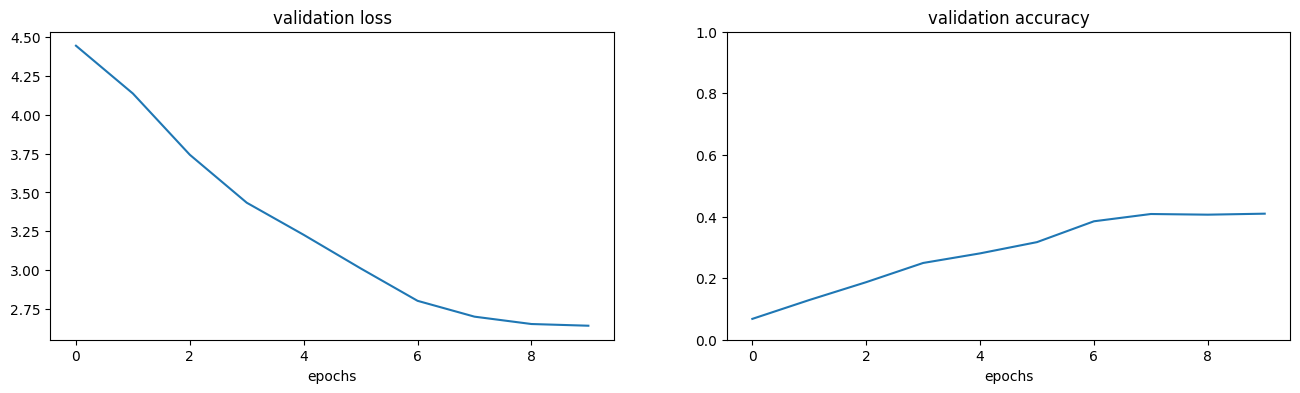

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.5282018184661865
Test accuracy: 0.42596566677093506


In [18]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 44s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [19]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [20]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
34/34 [==============================] - 388s 11s/step - loss: 4.1253 - accuracy: 0.1818 - val_loss: 3.1256 - val_accuracy: 0.3255
Epoch 2/10
34/34 [==============================] - 369s 11s/step - loss: 2.5682 - accuracy: 0.4406 - val_loss: 2.3616 - val_accuracy: 0.4791
Epoch 3/10
34/34 [==============================] - 361s 11s/step - loss: 1.9693 - accuracy: 0.5601 - val_loss: 2.0894 - val_accuracy: 0.5188
Epoch 4/10
34/34 [==============================] - 369s 11s/step - loss: 1.6339 - accuracy: 0.6341 - val_loss: 1.7867 - val_accuracy: 0.5704
Epoch 5/10
34/34 [==============================] - 378s 11s/step - loss: 1.3719 - accuracy: 0.6988 - val_loss: 1.5743 - val_accuracy: 0.6198
Epoch 6/10
34/34 [==============================] - 374s 11s/step - loss: 1.2367 - accuracy: 0.7181 - val_loss: 1.4435 - val_accuracy: 0.6660
Epoch 7/10
34/34 [==============================] - 374s 11s/step - loss: 1.1134 - accuracy: 0.7490 - val_loss: 1.4193 - val_accuracy: 0.6627
Epoch 

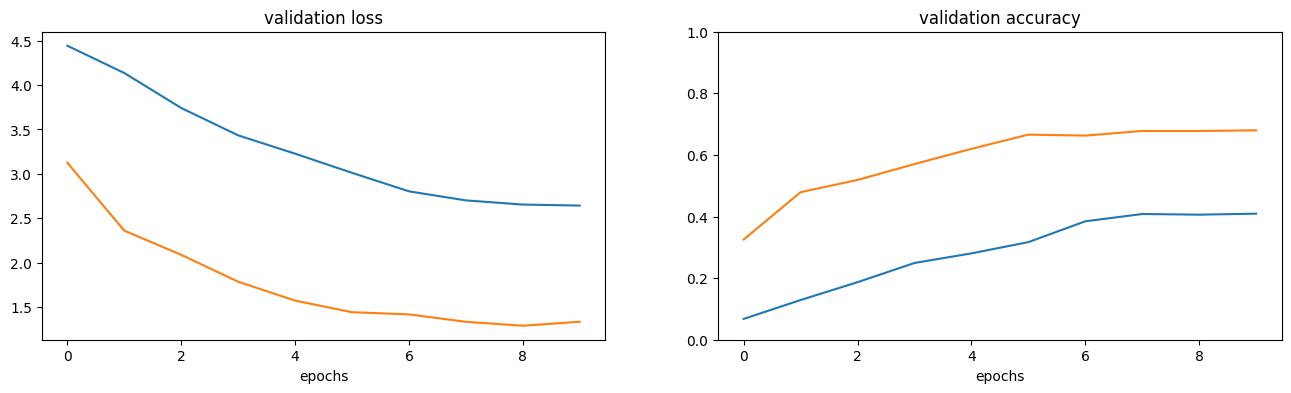

In [23]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [24]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.2827707529067993
Test accuracy: 0.6974248886108398


In [25]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])

1/1 [==============================] - 0s 231ms/step


In [26]:
probabilities

array([[5.54355080e-21, 9.88033982e-13, 3.28831537e-12, 2.74401104e-17,
        2.55169972e-22, 4.36446793e-20, 1.83046048e-12, 4.73920165e-13,
        5.11541899e-14, 3.79726801e-14, 2.71066044e-14, 6.11665937e-14,
        2.16961848e-14, 7.04879852e-08, 5.82600713e-01, 2.75658622e-05,
        5.05118834e-17, 3.40715889e-12, 1.97537634e-15, 1.07306134e-12,
        9.43907885e-09, 9.81332970e-09, 2.59126732e-13, 6.39649222e-09,
        3.84112536e-19, 1.16219022e-11, 7.92510235e-08, 7.68061829e-14,
        8.32881767e-12, 4.72711861e-07, 1.09075891e-11, 2.71485362e-20,
        8.86821472e-19, 9.01204092e-16, 1.31673461e-20, 2.74309863e-11,
        2.53435646e-13, 1.44019216e-14, 4.82704222e-14, 2.36828734e-11,
        7.58814333e-17, 1.03309332e-12, 1.72218658e-13, 2.61957247e-17,
        3.09848167e-15, 1.45453235e-12, 1.34562344e-11, 3.16304224e-23,
        4.57253591e-05, 7.76554247e-17, 2.51931897e-06, 7.27389802e-19,
        1.73229961e-14, 2.25736107e-16, 8.15810343e-19, 8.798868